In [52]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import database_credentials as dc

In [53]:
# Database credentials
postgres_user = dc.user()
postgres_pw = dc.pw()
postgres_host = dc.host()
postgres_port = dc.port()
postgres_db = dc.db()

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# no need for an open connection,
# as we're only doing a single query
engine.dispose()

In [54]:
# creating a table for order activity
sql = '''
select id, date(created_at), verb, driver_id, order_id, "text"
from ctms_db_public.activities_orderactivity
WHERE date(created_at) >= date(current_date - interval '28 days')
AND date(created_at) < date(current_date)
'''
order_activity = pd.read_sql_query(sql, con=engine)
order_activity = order_activity.rename(columns={'id': 'activity_id', 'date': 'created_at'})
order_activity

,activity_id,created_at,verb,driver_id,order_id,text
0,47651255,2020-12-11 22:59:44.848642,assigned,82014.0,7733061,Assigned to PABLO ZURITA
1,47652487,2020-12-11 23:23:37.356910,pickedup,50751.0,7754093,Ivan Matev marked the order as picked up from ...
2,47653719,2020-12-11 23:51:17.120156,delivered,74640.0,7756230,MARK LANGDELL marked the order as delivered to...
3,47654951,2020-12-12 00:21:26.911602,BOL_emailed,51567.0,7762706,BOL was emailed to duke@cli-mail.com
4,47656183,2020-12-12 01:07:59.753147,assigned,73640.0,7771799,Assigned to Claudia Flores
...,...,...,...,...,...,...
1114553,48519783,2021-01-04 22:15:14.548767,pickedup,55516.0,7894637,Lionel Villarreal marked the order as picked u...
1114554,48521015,2021-01-04 22:33:58.462920,assigned,58277.0,7911774,Assigned to Justin Lamb
1114555,48522247,2021-01-04 22:50:41.562770,deleted,NaN,7890219,Order was deleted
1114556,48523479,2021-01-04 23:10:45.339568,Invoice_emailed,NaN,7859987,Invoice was emailed to ship@rcglogistics.com


In [55]:
order_activity.isna().sum()/order_activity.isna().count()

activity_id    0.000000
created_at     0.000000
verb           0.000000
driver_id      0.303394
order_id       0.000000
text           0.000000
dtype: float64

There are many missing driver_id values. I am assuming this is because some of the activities are not performed by drivers. Since we are measuring driver activity, I will delete all missing values.

In [56]:
# value counts of order activities before deleting missing values
order_activity['verb'].value_counts()

assigned                               209561
delivered                              154098
pickedup                               152123
BOL_emailed                            116197
created                                102611
paid                                    77931
imported                                75188
Invoice_emailed                         62010
unassigned                              46144
archived                                43785
deleted                                 43023
qbo_invoice_sent                         9574
qbd_invoice_sent                         4886
unarchived                               3833
Invoice_faxed                            2928
qbo_payment_sent                         2309
Invoice_fax_delivered                    2200
added_order_terminal                     1486
delivered_to_terminal                    1360
Invoice_fax_failed                        682
restored                                  664
qbd_payment_sent                  

In [57]:
# dropping all missing values
order_activity.dropna(inplace=True)

In [58]:
# value counts of order activities after dropping missing values
order_activity['verb'].value_counts()

assigned                 209561
delivered                152282
pickedup                 151164
BOL_emailed              107855
unassigned                46144
created                   30339
deleted                   25486
imported                  22626
paid                      20968
archived                   8379
delivered_to_terminal      1352
BOL_faxed                   160
unarchived                   62
reassigned                   30
Name: verb, dtype: int64

In [59]:
# creating a table of drivers to get driver guid
sql = '''
SELECT genericuser_ptr_id, carrier_id, guid
FROM ctms_db_public.msd_driver
WHERE is_suspended = False
'''
drivers = pd.read_sql_query(sql, con=engine)
drivers = drivers.rename(columns={'guid': 'driver_guid', 'genericuser_ptr_id': 'driver_id'})
drivers.head()

,driver_id,carrier_id,driver_guid
0,38,20,c03bbd2c-bcf4-43bc-ac35-1a622cdf34f4
1,84,28,5e0349d6-6720-467b-b72d-f248e1be6c4d
2,101,42,bb8229f1-0cb5-46ac-8db8-05ebdb1561f0
3,117,5478,81fe5f04-ff57-4f09-b99b-86b4fab06347
4,136,5478,f65c4afc-6d34-4d74-9a0f-e7323ab305df


In [60]:
# joining driver_guid to order activity table

order_activity = order_activity.merge(drivers, how='inner', left_on='driver_id', right_on='driver_id')
order_activity

,activity_id,created_at,verb,driver_id,order_id,text,carrier_id,driver_guid
0,47651255,2020-12-11 22:59:44.848642,assigned,82014.0,7733061,Assigned to PABLO ZURITA,40497,400bf9e6-6ef0-4f37-8608-49af25622476
1,48161562,2020-12-23 14:56:30.671544,delivered,82014.0,7846626,PABLO ZURITA marked the order as delivered to ...,40497,400bf9e6-6ef0-4f37-8608-49af25622476
2,47762034,2020-12-15 14:12:08.645075,pickedup,82014.0,7784683,PABLO ZURITA marked the order as picked up fro...,40497,400bf9e6-6ef0-4f37-8608-49af25622476
3,48492942,2021-01-04 17:08:56.276674,assigned,82014.0,7906215,Assigned to PABLO ZURITA,40497,400bf9e6-6ef0-4f37-8608-49af25622476
4,48264795,2020-12-28 13:46:42.410950,BOL_emailed,82014.0,7861759,BOL was emailed to ballen@uadrinc.com,40497,400bf9e6-6ef0-4f37-8608-49af25622476
...,...,...,...,...,...,...,...,...
741012,48302773,2020-12-28 21:32:50.838057,BOL_emailed,8580.0,6499810,BOL was emailed to fmtrans@comcast.net,5274,fe9c7f9b-f411-419b-b36b-6f65ddd1d738
741013,48464250,2021-01-03 02:53:36.546086,assigned,79140.0,7900541,Assigned to Larry,41880,796d13ae-3140-41af-9a4d-d425052df76c
741014,48063550,2020-12-21 19:00:15.912541,assigned,61837.0,7838721,Assigned to James Benson,23748,d7bca87f-bed9-4753-b6d5-739c6588c443
741015,48485903,2021-01-04 15:53:11.810472,assigned,40519.0,7904731,Assigned to Anwar Mustafa,26610,1aeca3d7-1c0b-40e6-ab1d-4e7806da68dd


In [61]:
# Truncating date and time to the day instead of seconds
order_activity['created_at'] = pd.to_datetime(order_activity['created_at']).dt.date

In [66]:
result = order_activity.groupby(['driver_id', 'driver_guid']).nunique()[['created_at']]
result.reset_index(inplace=True)
result = result.rename(columns={'created_at': 'unique_days_of_activity'})

In [67]:
result

,driver_id,driver_guid,unique_days_of_activity
0,145.0,a705dfef-bd67-45d4-91cd-648673fade63,16
1,154.0,e482e9b0-8ab7-490c-8fcd-07cfa71e53d9,7
2,174.0,27abbc41-fa85-46c9-9545-418a2fd2d05a,5
3,175.0,95b49d52-c6bb-4ff1-afb0-ab58b9708970,17
4,186.0,c16b55c8-8b3f-4d28-bb96-3fbf4619ab52,23
...,...,...,...
10829,84301.0,922bfb70-0af9-4aa2-954e-8ba8a45f8905,1
10830,84305.0,627816ac-84cb-4339-9b5b-39837649cf1d,1
10831,84307.0,f7d76531-3cb3-48a7-ad7d-dff8fc162476,1
10832,84309.0,987ab149-743b-4e21-adc0-a3a95fb131c3,1


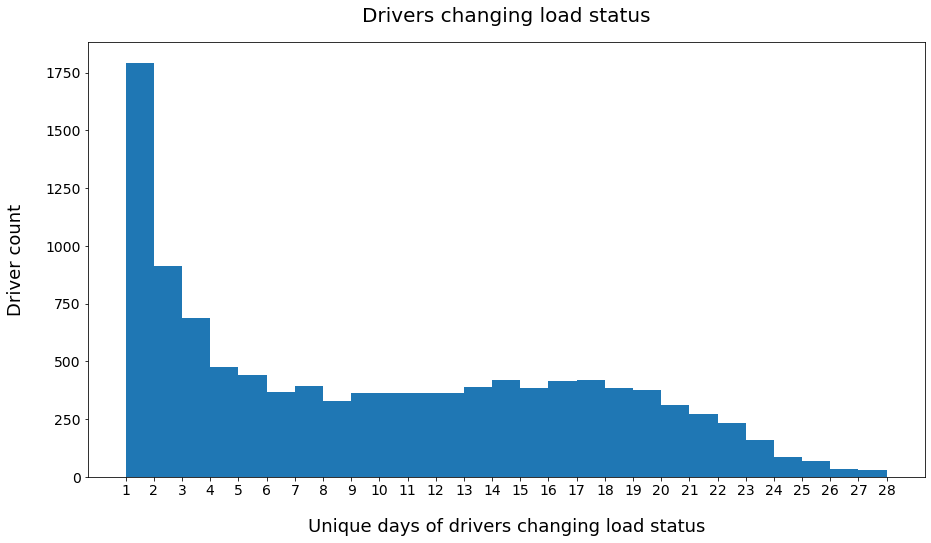

In [68]:
# histogram of unique days of driver activity (changing load status)
plt.figure(figsize=(15,8))
plt.hist(result['unique_days_of_activity'], bins=np.arange(1, 29))
plt.xticks(np.arange(1, 29), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Unique days of drivers changing load status', fontsize=18, labelpad=20)
plt.ylabel('Driver count', fontsize=18, labelpad=20)
plt.title('Drivers changing load status', fontsize=20, pad=20)
plt.show()